In [300]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import warnings 
warnings.filterwarnings("ignore")

import os
os.environ["RF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [301]:
df=pd.read_csv("international-airline-passengers.csv")

In [302]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [303]:
df=df.dropna(how='any',axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   Month                                                                           144 non-null    object 
 1   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [304]:
df.columns=["Months","Passengers"]

In [305]:
df

,Months,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


In [306]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [307]:
df["Months"]=pd.to_datetime(df["Months"])

In [308]:
df


,Months,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
139,1960-08-01,606.0
140,1960-09-01,508.0
141,1960-10-01,461.0
142,1960-11-01,390.0


In [309]:
df.index=df["Months"]

In [310]:
df.drop("Months",axis=1,inplace=True)

In [311]:
df

,Passengers
Months,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


<AxesSubplot:xlabel='Months'>

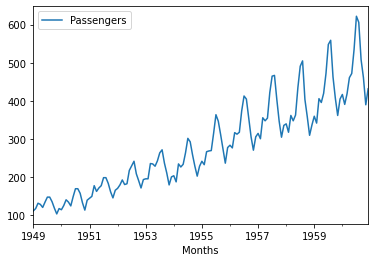

In [312]:
df.plot()

In [313]:
data=df["Passengers"].values

In [314]:
data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [315]:
data=data.astype("float32")

In [316]:
data=data.reshape(-1,1)

In [317]:
def split_data(dataframee,test_size):
    pos=int(round(len(dataframee)*(1.0-test_size)))
    train=dataframee[:pos]
    test=dataframee[pos:]
    return train,test,pos

In [352]:
train, test, pos=split_data(data,0.3)

In [353]:
print(train.shape,test.shape)

(101, 1) (43, 1)


In [354]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [355]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        Y.append(data[i, 0])
        
    return np.array(X), np.array(Y)

In [356]:
lookback=1

In [357]:
X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)


In [358]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(100, 1) (100,) (42, 1) (42,)


In [359]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(100, 1) (100,) (42, 1) (42,)


In [385]:

model = Sequential()
model.add(SimpleRNN(units=64, activation="relu",input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_49 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [386]:
callbacks=[EarlyStopping(monitor="val_loss",patience=4,verbose=1,mode="min"),
           ModelCheckpoint(filepath="mymodel.h5",save_weights_only=False,monitor='val_loss',mode='min',save_best_only=True)]
           

In [387]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=10,
                    epochs=100,
                    callbacks=callbacks,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test,y_test))

Epoch 1/100
10/10 [==============================] - 1s 20ms/step - loss: 0.2293 - val_loss: 0.1751
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1617 - val_loss: 0.1158
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1032 - val_loss: 0.0755
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0640 - val_loss: 0.0514
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0410 - val_loss: 0.0388
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0372 - val_loss: 0.0333
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0315
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0307
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0300
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0290
Epoch 11

In [388]:
loss=model.evaluate(X_test,y_test,batch_size=10)
print("test loss: %.1f%%"%(100*loss))

5/5 [==============================] - 0s 1ms/step - loss: 0.0219
test loss: 2.2%


In [389]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 999us/step


In [390]:
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)


In [391]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [392]:
np.sqrt(mean_squared_error(y_train,train_predict))

228.6577

In [393]:
np.sqrt(mean_squared_error(y_test,test_predict))

428.84476

In [394]:
train_predicted_df=df[lookback:pos]
train_predicted_df["train_Predicted"]=train_predict

test_predict_df=df[lookback+pos:]
test_predict_df["test_Predicted"]=test_predict

In [395]:
train_predicted_df

,Passengers,train_Predicted
Months,,
1949-02-01,118.0,126.202156
1949-03-01,132.0,131.272171
1949-04-01,129.0,143.373413
1949-05-01,121.0,140.752777
1949-06-01,135.0,133.807175
...,...,...
1957-01-01,315.0,295.710052
1957-02-01,301.0,302.811035
1957-03-01,356.0,291.765045


In [396]:
test_predict_df

,Passengers,test_Predicted
Months,,
1957-07-01,465.0,426.374878
1957-08-01,467.0,464.409149
1957-09-01,404.0,465.987152
1957-10-01,347.0,409.909943
1957-11-01,305.0,357.532440
1957-12-01,336.0,321.365112
1958-01-01,340.0,347.444946
1958-02-01,318.0,351.113129
1958-03-01,362.0,331.826996


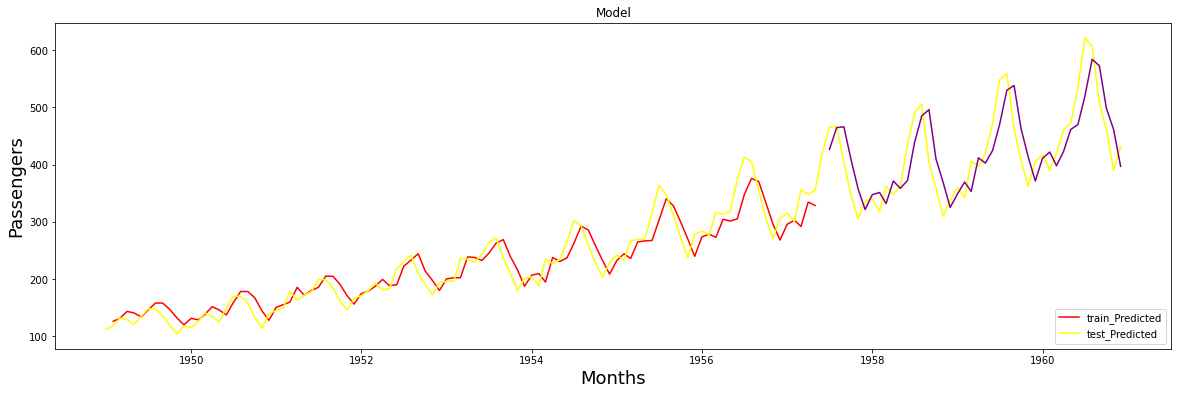

In [397]:
plt.figure(figsize=(20,6))
plt.title('Model')
plt.xlabel('Months', fontsize=18)
plt.ylabel('Passengers', fontsize=18)
plt.plot(train_predicted_df["train_Predicted"],color="red")
plt.plot(df["Passengers"],color="yellow")
plt.plot(test_predict_df["test_Predicted"],color="purple")

plt.legend(['train_Predicted', 'test_Predicted'], loc='lower right')